# 09. PyTorch Model deployment


## 0. Get setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3469 (delta 20), reused 40 (delta 17), pack-reused 3423
Receiving objects: 100% (3469/3469), 642.18 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (1990/1990), done.
Updating files: 100% (222/222), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
1. Where is my model going to go?
1. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30ms latency)

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor
1. ViT feature extractor

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers changed to the certain problem.

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effenetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get the transforms
effnetb2_transforms = effenetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effenetb2_weights)

# 4. Freeze the base layers in the model
for param in effnetb2.parameters():
  param.requires_grad = False

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int  = 42,
                          ):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

### 3.2 Creating DataLoaders for EffNetB2

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnet2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnet2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Train function
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnet2,
                                epochs=10,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 loss curves

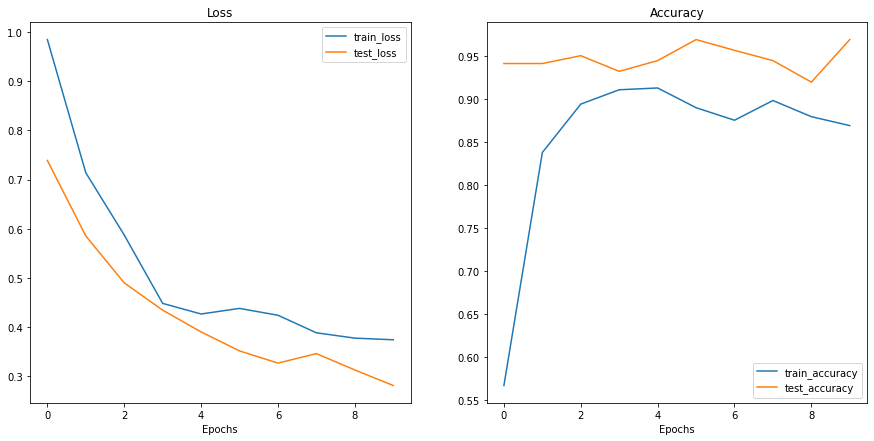

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extrator

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pss_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pss_20_percent.pth


### 3.6 Inspecting size of our EffNetB2 feature extractor

In [ ]:
from pathlib import Path

# Get the model size in convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pss_20_percent.pth").stat().st_size / (1024**2)
pretrained_effnetb2_model_size

29.852089881896973

### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "num_params": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'num_params': 7705221,
 'model_size (MB)': 29.852089881896973}

## 4. Creating a ViT feature extractor

In [ ]:
# Checkout the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
  # Create ViT_B_16: pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head
  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

### 4.1 Create DataLoaders for ViT feature extractor

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=vit_transforms,
                                                                                                batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT feature extractor

In [ ]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Train function
set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

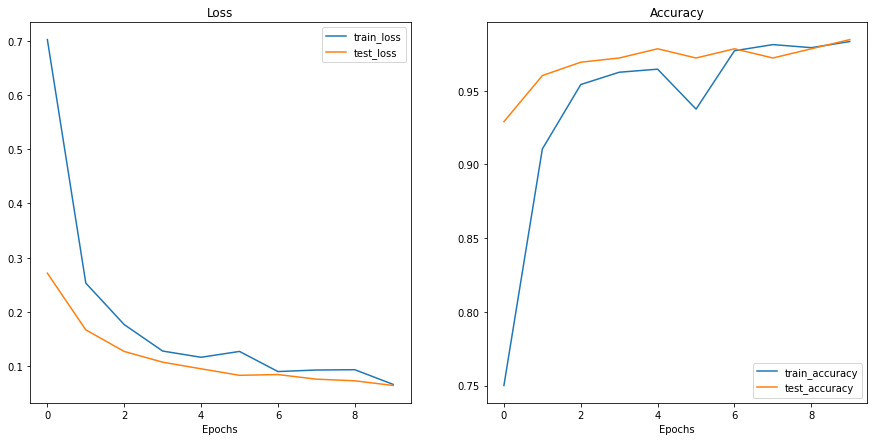

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extrator

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pss_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pss_20_percent.pth


### 4.5 Inspecting size of our ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size in convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pss_20_percent.pth").stat().st_size / (1024**2)
pretrained_vit_model_size

327.3682699203491

### 4.6 Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "num_params": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'num_params': 85800963,
 'model_size (MB)': 327.3682699203491}

## 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
1. Fast (30+ FPS)

To test criteria two:
1. Loop through test images
1. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1245545.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/780283.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1844723.jpg')]

### 5.1 Creating a function to make predictions across test dataset

1. Creating a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
1. Create an empty list (can return a full list of all predictions later).
1. Loop through the target input paths
1. Create an empty dictionary for each sample
1. Get the sample path and ground truth label class from the filepath
1. Start the prediction timer
1. Open the image using `PIL.Image.open(path)`
1. Transform the image to be used with a given model.
1. Prepare the model for inference by sending it to the target device and tuning on `eval` mode.
1. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
1. Add the pred prob + pred class to empty dictionary from step 4.
1. End prediction timer and add time to the prediction dictionary
1. See if the predicted class matches the ground truth class.
1. Return the list og prediction dictionaries.

In [ ]:
from typing import List, Dict
from pathlib import Path
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transforms: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  for path in tqdm(paths):

    pred_dict = {}

    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    start_time = timer()

    img = Image.open(path)

    transformed_image = transforms(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class
    
      end_time = timer()

      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and timing predictions with EffNetB2

Two things to note:
1. Device - we're going to hardcode our predcitions to happen on CPU
1. Transforms - we want to make sure each of the models are predicting on imgaes with appropriate transforms.

In [ ]:
# Make predictions test dataset with EffNetB2
effnetb2_test_preds_dicts = pred_and_store(paths=test_data_paths,
                                           model=effnetb2,
                                           transforms=effnetb2_transforms,
                                           class_names=class_names,
                                           device="cpu")
effnetb2_test_preds_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.7971,
  'pred_class': 'sushi',
  'time_for_pred': 0.2699,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1245545.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9246,
  'pred_class': 'sushi',
  'time_for_pred': 0.0992,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_preds_dicts)
effnetb2_test_pred_df.head(3)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.7971,sushi,0.2699,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9246,sushi,0.0992,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9183,sushi,0.0989,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [ ]:
# Find the average timer per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1132


In [ ]:
# Add time per perd to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred"] = effnetb2_average_time_per_pred

> **Note:** Prediction times will vary depending on the hardware you're using...

### 5.3 Making and timing predictions of ViT

In [ ]:
# Make predictions test dataset with EffNetB2
vit_test_preds_dicts = pred_and_store(paths=test_data_paths,
                                           model=vit,
                                           transforms=vit_transforms,
                                           class_names=class_names,
                                           device="cpu")
vit_test_preds_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9975,
  'pred_class': 'sushi',
  'time_for_pred': 0.6873,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1245545.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9859,
  'pred_class': 'sushi',
  'time_for_pred': 0.5441,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_preds_dicts)
vit_test_pred_df.head(3)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9975,sushi,0.6873,True
1,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9859,sushi,0.5441,True
2,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9927,sushi,0.5290,True


In [ ]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
# Find the average timer per prediction
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.5947


In [ ]:
# Add time per perd to ViT stats dictionary
vit_stats["time_per_pred"] = vit_average_time_per_pred

## 6. Comparing model results, predcition times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df['model'] = ["EffNetB2", "ViT"]

# Convert acc to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,num_params,model_size (MB),time_per_pred,model
0,0.280864,96.88,7705221,29.85209,0.1132,EffNetB2
1,0.064182,98.47,85800963,327.36827,0.5947,ViT


### 6.1 Visualizing the speed vs performance tradeoff

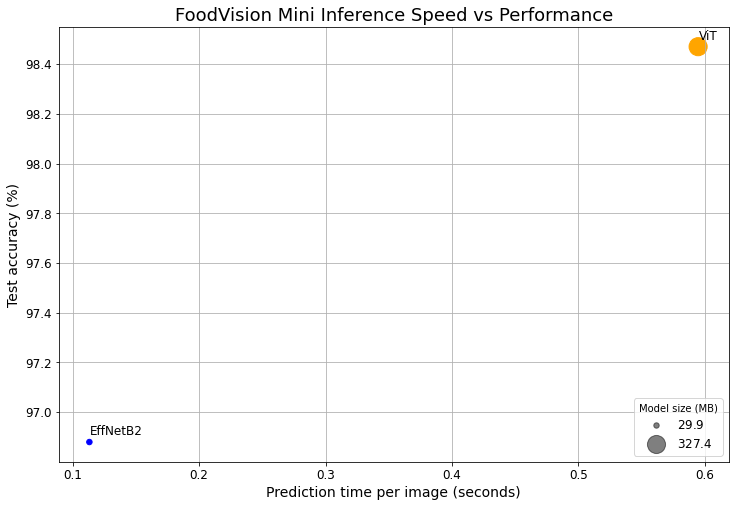

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by creating Gradio app

In [ ]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.1 MB/s eta 0:00:

### 7.1 Creating a function to map our inputs and outputs

In [ ]:
# Put our model to the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label)
```

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Read in the image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/697562.jpg

{'pizza': 0.1575547754764557, 'steak': 0.7372724413871765, 'sushi': 0.10517267882823944}
0.49818


## 7.2 Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/720302.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg']]

### 7.3 Building a Gradio interface

In [ ]:
import gradio as gr

# Creating title, decription and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
# demo.launch(debug=False,
#             share=True)

## 8. Turning our FoodVision Mini Demo into a deployable app

### What is Hugging Face Spaces?


### 8.1 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all Gradio files -> Upload app files to Hugging Face Spaces -> deploy
```

By the end our file structure will look like:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 8.2 Creating a `demos` folder to store our FoodVision Mini app files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision Mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)

### 8.3 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an examples directory
* Images should be from the test set

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Let's verify that we can get a list of lists from our `examples/` directory

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

### 8.4 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor.pth"

# Create a dest path
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  
  print(f"[INFO] Model move complete")
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor.pth
[INFO] No model found at models/09_pretrained_effnetb2_feature_extractor.pth
[INFO] Model exists at demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor.pth: False


### 8.5 Creating `model.py`

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


### 8.6 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

In [ ]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names))

# Load weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False)

Overwriting demos/foodvision_mini/app.py


### 8.7 Creating a requirements file for FoodVision Mini (`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying FoodVision Mini App on Hugging Face Spaces

### 9.1 Downloading our FoodVision Mini app files

In [ ]:
!ls demos/foodvision_mini

app.py	examples  model.py  requirements.txt


In [ ]:
# Change into the food vision mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

updating: app.py (deflated 57%)
updating: examples/ (stored 0%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

See the steps here: https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
# IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big!!!

### 10.1 Creating a model for FoodVision Big + transforms

In [ ]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
food101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

### 10.2 Getting data for FoodVision Big

In [ ]:
from torchvision import datasets

# Setup data directory
data_dir = Path("data")

# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_transforms,
                              download=True)

# Get the test data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test dataset.

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))
  
  return random_split_1, random_split_2

In [ ]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                              split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                             split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


### 10.4 Turning our Food101 dataset into dataloaders

In [ ]:
import torch
import os

BATCH_SIZE = 32
NUM_WORKERS = 2

# Create Food101 20 training dataloaders
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20 testing dataloaders
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big!!!

Things for training:
- 5 epochs
- Optimizer: `torch.optim.Adam(lr=1e-3)`
- Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`


In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food_101_results = engine.train(model=effnetb2_food101,
                                         train_dataloader=train_dataloader_food101_20_percent,
                                         test_dataloader=test_dataloader_food101_20_percent,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=5,
                                         device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6417 | train_acc: 0.2804 | test_loss: 2.7815 | test_acc: 0.4915
Epoch: 2 | train_loss: 2.8621 | train_acc: 0.4410 | test_loss: 2.4731 | test_acc: 0.5332
Epoch: 3 | train_loss: 2.6545 | train_acc: 0.4861 | test_loss: 2.3638 | test_acc: 0.5566
Epoch: 4 | train_loss: 2.5437 | train_acc: 0.5140 | test_loss: 2.3022 | test_acc: 0.5735
Epoch: 5 | train_loss: 2.4955 | train_acc: 0.5252 | test_loss: 2.2800 | test_acc: 0.5802


### 10.6 Inspecting loss curves of FoodVision Big model

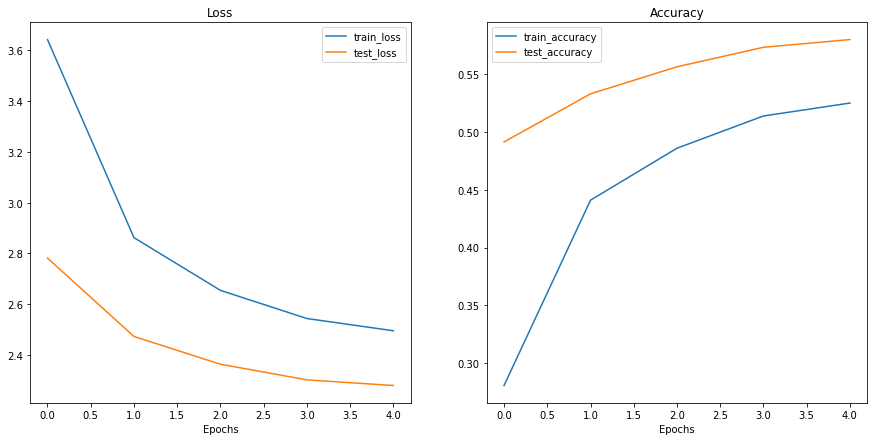

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food_101_results)

### 10.7 Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# Create model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking our FoodVision Big model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning our FoodVision Big model into a deployable app

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory

In [ ]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2023-03-11 05:11:56--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2023-03-11 05:11:57 (206 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (class_names.txt)

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head. 
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model. 
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
      param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes),
  )
  
  return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
  class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start the timer
  start_time = timer()
  
  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)
  
  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
      # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
      pred_probs = torch.softmax(effnetb2(img), dim=1)
  
  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  
  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)
  
  # Return the prediction dictionary and prediction time 
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_big/app.py


### 11.6 Downloading our FoodVision Big app files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 4%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>